# Amozon reviews-Automobile


# Introducing Data

In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
!pip install pyspark py4j
!pip install findspark
os.environ['KAGGLE_USERNAME'] = "besimsakaoglu"
os.environ['KAGGLE_KEY'] = "eff3f17c8e73c3303a2ffb896e2d09be"
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset


amazon-us-customer-reviews-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import networkx as nx
import numpy as np
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, array_contains
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql import functions as f
import itertools
import tempfile
import shutil
import zipfile
import math
import matplotlib.pyplot as plt
import csv
from google.colab import files
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

Create a Spark session named "AmazonReviews".
Extract a TSV file from a ZIP archive, reads it into a Spark DataFrame (df), and limits the number of rows to 10,000 (**Applicable-suitable for scalability of the proposed solution to entire dataset denoted on the Task evaluation criterias** but due to the storage and time constraint I have chosen this amount of rows) for Automative reviews.
Selects specific columns ("customer_id", "review_id", "product_id", "product_title") from the DataFrame, creating a new Spark DataFrame named selected_df.
Displays the first 30 rows of the selected_df DataFrame.

In [4]:
import zipfile
import tempfile
import shutil
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("AmazonReviews").getOrCreate()

zip_file = zipfile.ZipFile('/content/amazon-us-customer-reviews-dataset.zip')
review_file = "amazon_reviews_us_Automotive_v1_00.tsv"
temp_dir = tempfile.mkdtemp()
zip_file.extract(review_file, path=temp_dir)
extracted_file_path = f"{temp_dir}/{review_file}"

local_file_path = "/tmp/amazon_reviews_us_Automotive_v1_00.tsv"
shutil.move(extracted_file_path, local_file_path)

# Read the TSV file into a DataFrame and limit the number of rows to 10000 we can extend to all data but for now ineffecient for storage and time limitation
df = spark.read.option("delimiter", "\t").option("header", "true").option("inferSchema", "true").csv(local_file_path)#.limit(10000) #10000 can be scalable or just remove .limit

# Select specific columns from the DataFrame
selected_df = df.select("customer_id" , 'review_id',"product_id",'product_title')

# Show the selected DataFrame
selected_df.show(30)





+-----------+--------------+----------+--------------------+
|customer_id|     review_id|product_id|       product_title|
+-----------+--------------+----------+--------------------+
|   36075342| RAB23OVFNCXZQ|B00LPRXQ4Y|17" 2003-2006 For...|
|   42462164|R3NORADVJO6IE6|B000C7S0TO|Spectra Premium C...|
|   21241933|R299F4SO98S5OO|B000CO9WE4|K&N E-4665 High P...|
|   52570308|R2DA9DOT03UW6I|B000GKD5NI|Suncutters Rear W...|
|   38200102|R2OGCH681EQHU6|B009SDA7TE|Lug Nuts Landcrui...|
|   34866169| R2JMKIC16MHD7|B00KV15KRG|Fits 2007-2009 Ho...|
|     184627|R1DB5DA7CWWTI8|B0002JMAKW|Castrol 12614 Dot...|
|    2975964|R1N8XWFDK4QACP|B00XJKMM6S|New Power Window ...|
|   40946484|R19VFLX6MRU0CX|B000C5CEKC|Motorad MGC-791 L...|
|   12554469| RLTD8YDGTP9PT|B00GD9R2A8|Genuine Ford AL3Z...|
|   35335277| R78B5LCFJ52SR|B00RM327NG|Air Vent Smartpho...|
|   44957003|R33SKWL0HEQIQ9|B0071NL7UQ|FDJ New Replaceme...|
|     444125|R1HIOV0UX7P13D|B00DSOL0FY|Omix-Ada 17402.09...|
|   35829199| R4WS0E0MSP

There are **no null values** if we want to double check, we can use the code chunk belove



In [5]:
## List columns with null values
##columns_with_null = [column for column in df.columns if df.filter(expr(f"{column} IS NULL")).count() > 0]

#if columns_with_null:
  ##  columns_with_null_str = ', '.join(columns_with_null)
 ##  print(f"Columns with null values: {columns_with_null_str}")
#else:
 ##   print("No columns contain null values.") ##

# ***(EDA part) Exploratory Data Analysis***

In [6]:
df.printSchema() # can be checked more detailed on https://huggingface.co/datasets/amazon_us_reviews#automotive_v1_00  or original kaggle page

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



 **products` popularity** or significance among customers. helps we can extract valuable information about consumer preferences, trends, and market demand.

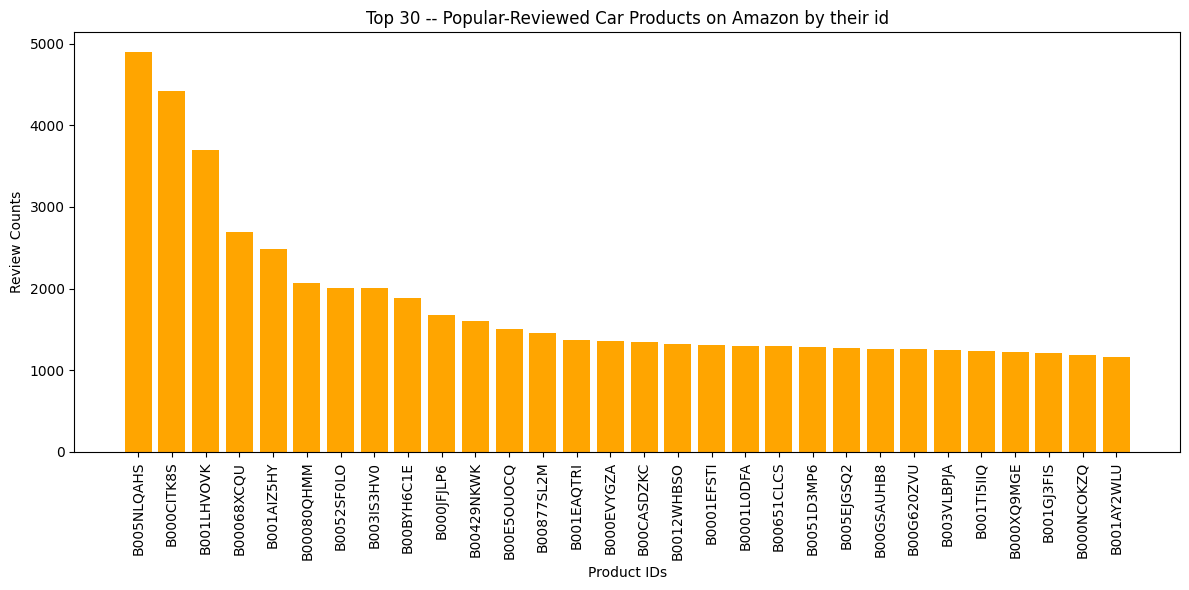

+----------+-----+
|product_id|count|
+----------+-----+
|B005NLQAHS| 4894|
|B000CITK8S| 4422|
|B001LHVOVK| 3694|
|B00068XCQU| 2688|
|B001AIZ5HY| 2483|
|B00080QHMM| 2069|
|B0052SF0LO| 2011|
|B003IS3HV0| 2003|
|B00BYH6C1E| 1886|
|B000JFJLP6| 1679|
|B00429NKWK| 1609|
|B00E5OUOCQ| 1511|
|B00877SL2M| 1457|
|B001EAQTRI| 1369|
|B000EVYGZA| 1361|
|B00CASDZKC| 1346|
|B0012WHBSO| 1318|
|B0001EFSTI| 1313|
|B0001L0DFA| 1299|
|B00651CLCS| 1293|
|B0051D3MP6| 1291|
|B005EJGSQ2| 1273|
|B00GSAUHB8| 1260|
|B00G620ZVU| 1256|
|B003VLBPJA| 1245|
|B001TI5IIQ| 1241|
|B000XQ9MGE| 1226|
|B001GJ3FIS| 1207|
|B000NCOKZQ| 1186|
|B001AY2WLU| 1166|
+----------+-----+



In [7]:
# top 30 reviewed products on Amazon identified by product id
n = 30

import matplotlib.pyplot as plt

# Calculate product review counts
product_counts = df.groupBy("product_id").count().orderBy("count", ascending=False).limit(30)

# Extract product IDs and counts for plotting
product_ids = [row["product_id"] for row in product_counts.collect()]
review_counts = [row["count"] for row in product_counts.collect()]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(product_ids, review_counts, color='orange')
plt.xlabel("Product IDs")
plt.ylabel("Review Counts")
plt.title("Top 30 -- Popular-Reviewed Car Products on Amazon by their id")
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

product_counts.show(n)



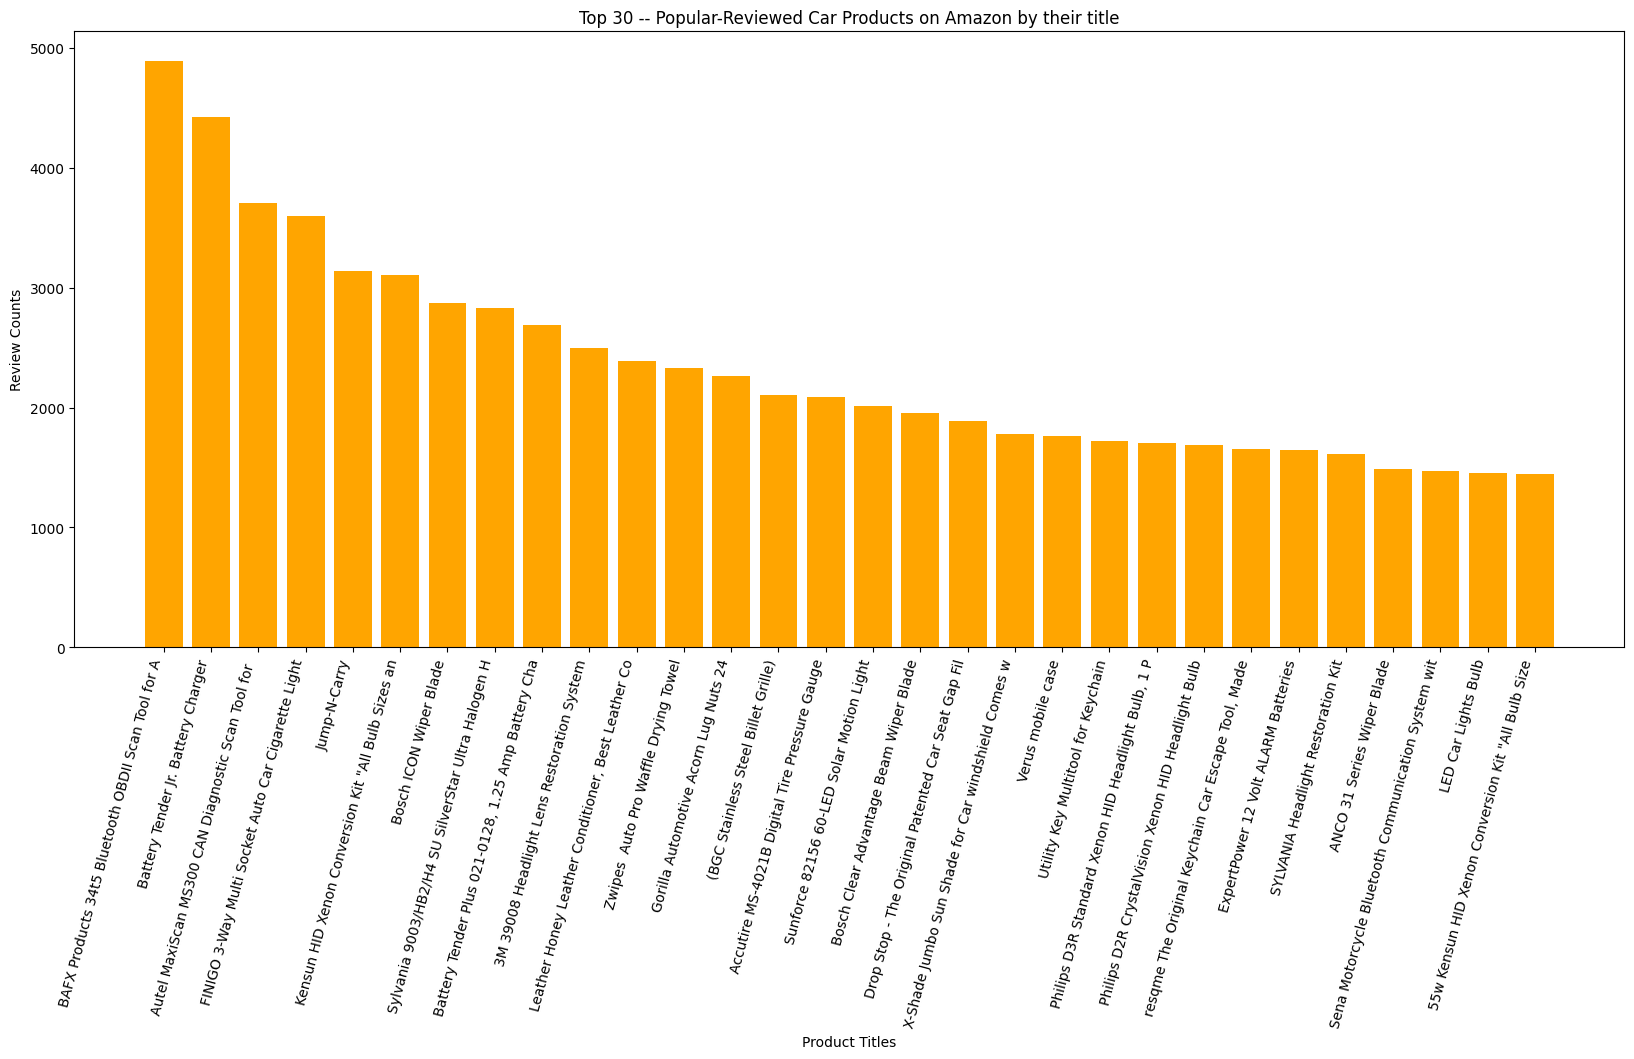

+--------------------+-----+
|       product_title|count|
+--------------------+-----+
|BAFX Products 34t...| 4894|
|Battery Tender Jr...| 4422|
|Autel MaxiScan MS...| 3704|
|FINIGO 3-Way Mult...| 3598|
|        Jump-N-Carry| 3141|
|Kensun HID Xenon ...| 3105|
|Bosch ICON Wiper ...| 2873|
|Sylvania 9003/HB2...| 2833|
|Battery Tender Pl...| 2688|
|3M 39008 Headligh...| 2495|
|Leather Honey Lea...| 2392|
|Zwipes  Auto Pro ...| 2333|
|Gorilla Automotiv...| 2266|
|(BGC Stainless St...| 2104|
|Accutire MS-4021B...| 2089|
|Sunforce 82156 60...| 2011|
|Bosch Clear Advan...| 1954|
|Drop Stop - The O...| 1886|
|X-Shade Jumbo Sun...| 1783|
|   Verus mobile case| 1760|
|Utility Key Multi...| 1723|
|Philips D3R Stand...| 1702|
|Philips D2R Cryst...| 1690|
|resqme The Origin...| 1651|
|ExpertPower 12 Vo...| 1643|
|SYLVANIA Headligh...| 1609|
|ANCO 31 Series Wi...| 1492|
|Sena Motorcycle B...| 1468|
| LED Car Lights Bulb| 1457|
|55w Kensun HID Xe...| 1447|
+--------------------+-----+



In [8]:
# top 30 reviewed car products identified by product title instead of product id - farkli cunku prod_id is unique identifer title degildir
n = 30

import matplotlib.pyplot as plt

# Calculate product review counts by title
product_counts = df.groupBy("product_title").count().orderBy("count", ascending=False).limit(30)

# Extract product titles and counts for plotting
max_title_length = 50  # maximum length for product titles since originally some of them are more than 90 characters
product_titles = [row["product_title"][:max_title_length] for row in product_counts.collect()]
review_counts = [row["count"] for row in product_counts.collect()]

# Create a bar plot
plt.figure(figsize=(20, 8))
plt.bar(product_titles, review_counts, color='orange')
plt.xlabel("Product Titles")
plt.ylabel("Review Counts")
plt.title("Top 30 -- Popular-Reviewed Car Products on Amazon by their title")
plt.xticks(rotation=75, ha="right")  # Rotate labels since product titles are too long
#plt.tight_layout()

# Show the plot
plt.show()
product_counts.show(n)

# ***Checking average star ratings***
I thought that checking average star ratings is beneficial Explonatary Data Analysis (EDA). For further inspection, I may expand it by performing additional analysis by visualizing the distribution of star ratings for these top products, or identifying patterns between high-rated products and certain review attributes.

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|product_title                                                                                                                                                                                         |avg_star_rating|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|ARKON AP036 70mm Adhesive Mounting Disk for Car Dashboards Garmin TomTom GPS Dashboard Disc                                                                                                           |5.0            |
|VW (87-95) a/c heater hvac Blower Motor Resistor FEBI corrado golf jetta 1.6                                                       

<ipython-input-9-4b0b85f2cf52>:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


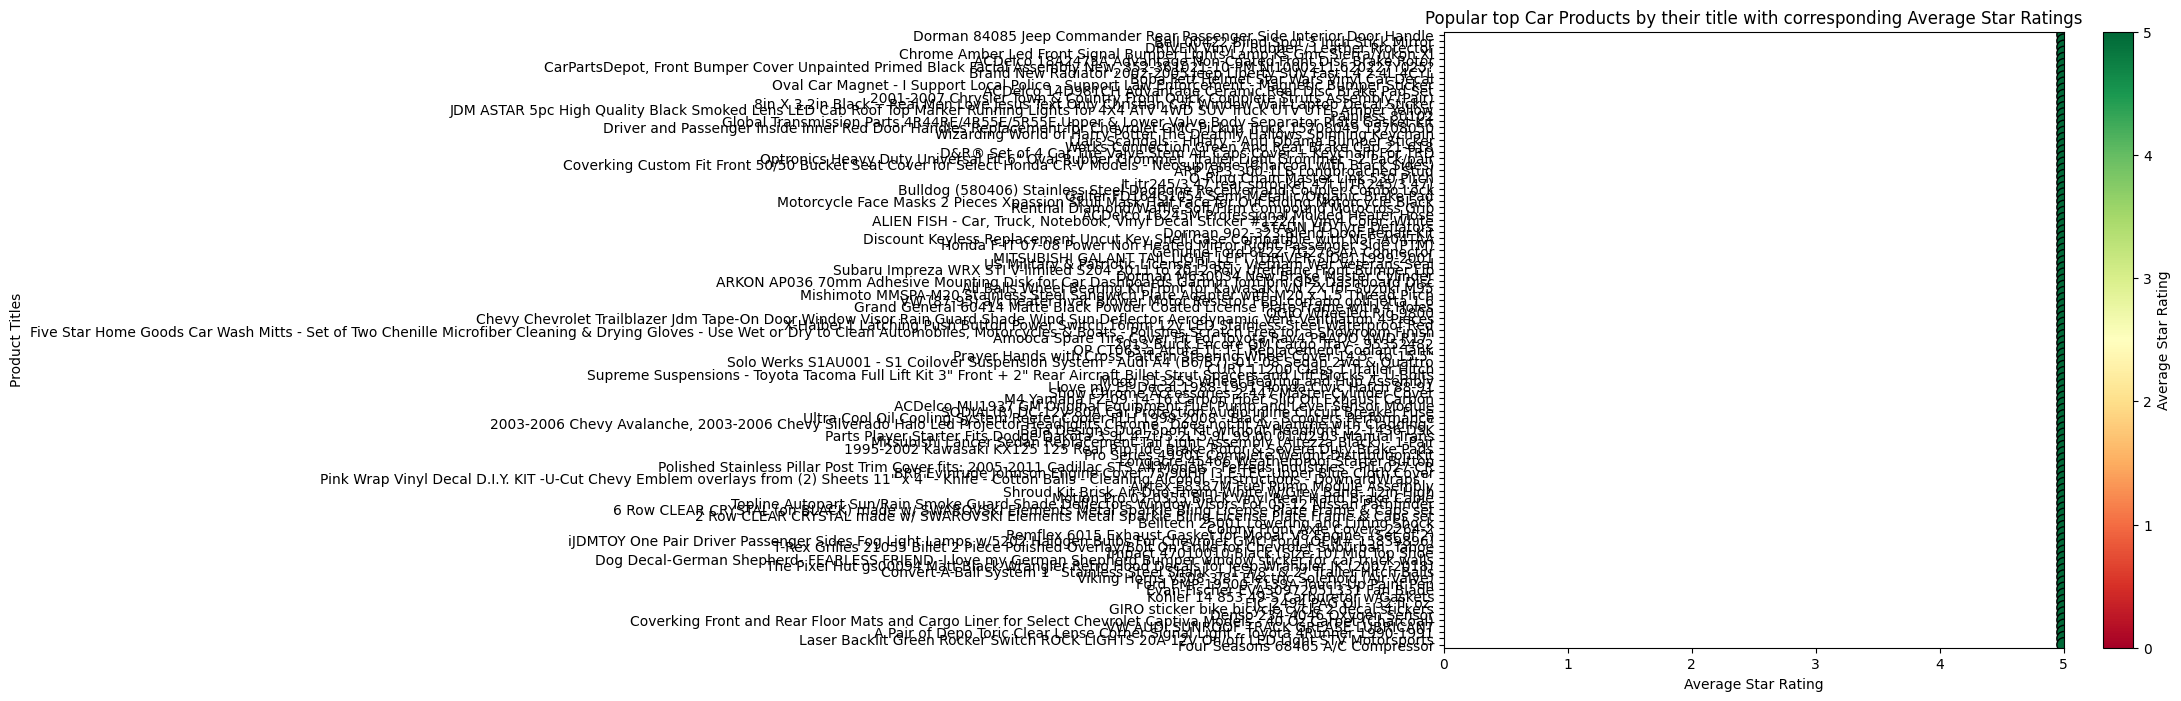

In [9]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, desc
# Calculate average star ratings for top 100 products
top_products = df.groupBy("product_title").agg(avg("star_rating").alias("avg_star_rating")).orderBy(desc("avg_star_rating")).limit(100)

# Show top products with average star ratings
top_products.show(truncate=False)

# Extract product titles and average ratings
product_titles = [row["product_title"] for row in top_products.collect()]
avg_ratings = [row["avg_star_rating"] for row in top_products.collect()]

# Specify a font that supports a wide range of Unicode characters
plt.rcParams["font.family"] = "DejaVu Sans"

# Create a scatter plot with varying colors
plt.figure(figsize=(10, 8))
plt.scatter(avg_ratings, product_titles, c=avg_ratings, cmap='RdYlGn', edgecolors='k', s=100, vmin=0, vmax=5.0)
plt.colorbar(label="Average Star Rating")
plt.xlabel("Average Star Rating")
plt.ylabel("Product Titles")
plt.title("Popular top Car Products by their title with corresponding Average Star Ratings")
plt.xlim(0, 5)  # Set x-axis limits to 0 and 5 (star rating scale)
plt.ylim(-0.5, len(product_titles) - 0.5)  # Adjust y-axis limits
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rating at the top
plt.tight_layout()

# Show the plot
plt.show()


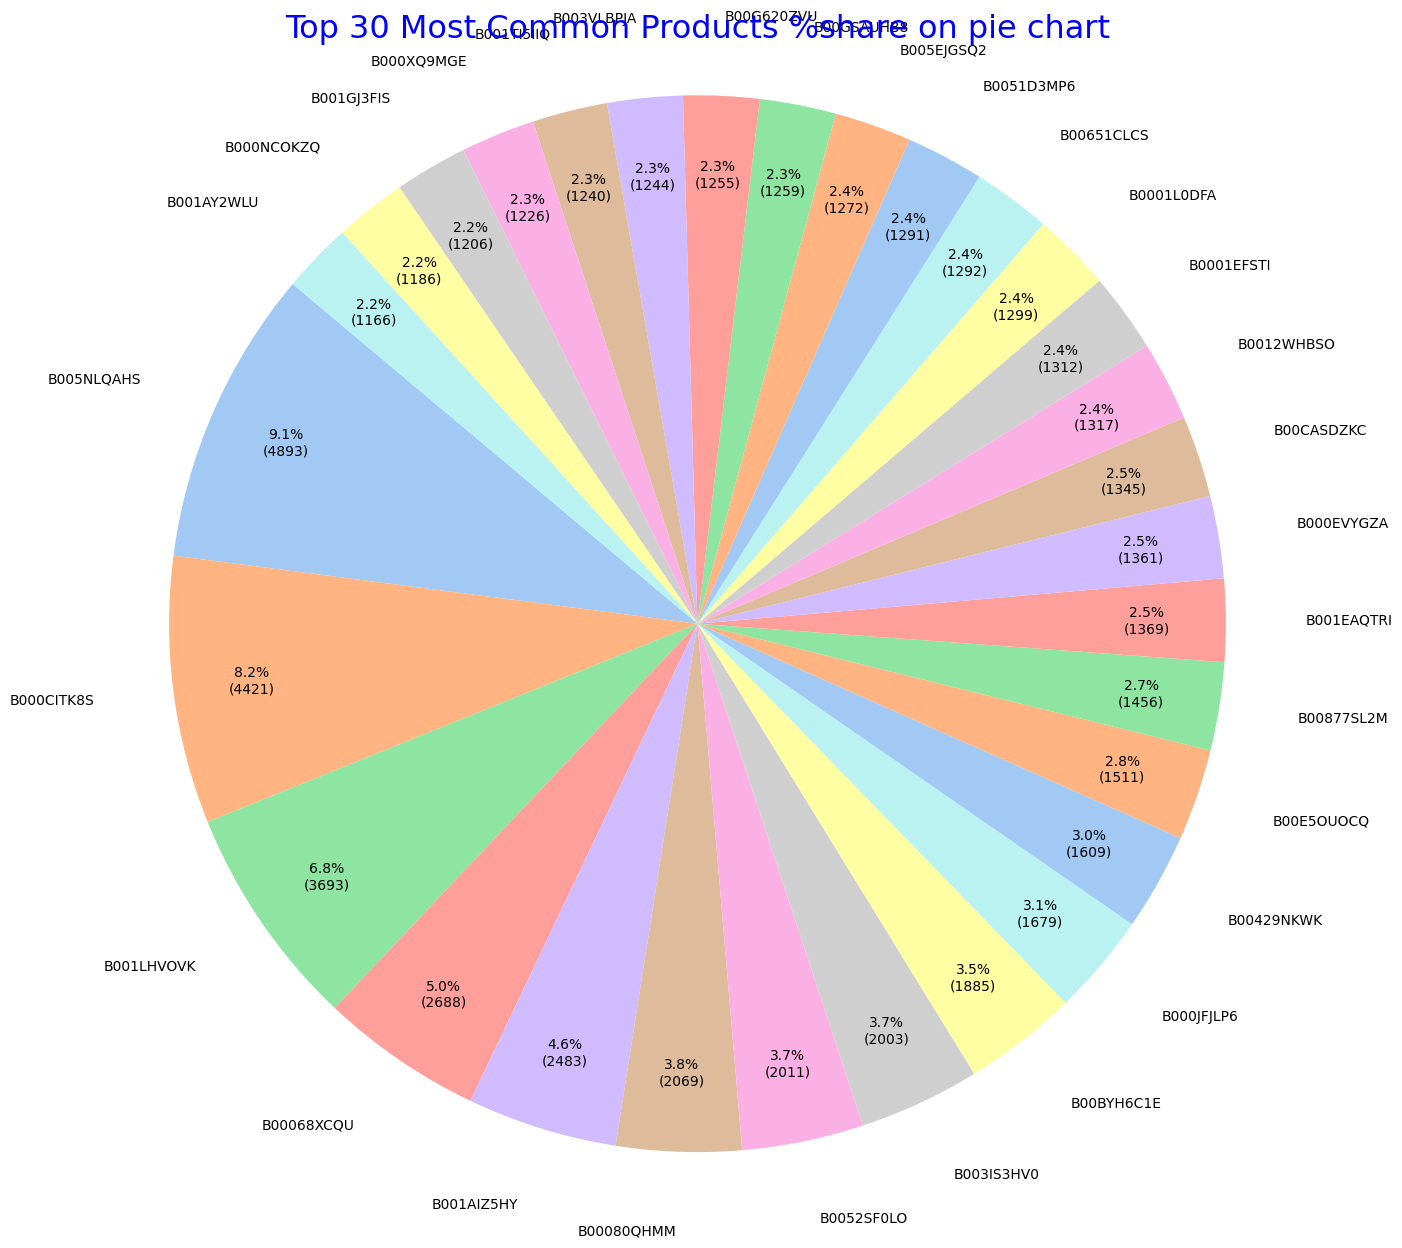

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Count occurrences of each unique product_id
product_counts = df.groupBy("product_id").count().orderBy(col("count").desc()).limit(n)

# Convert the result to a pandas DataFrame for plotting
product_counts_pd = product_counts.toPandas()

#  color palette for the pie chart
colors = sns.color_palette("pastel")[0:len(product_counts_pd)]

#  pie chart construction
plt.figure(figsize=(15, 15))
plt.pie(product_counts_pd["count"], labels=product_counts_pd["product_id"], colors=colors,
        autopct=lambda p: f"{p:.1f}%\n({int(p*sum(product_counts_pd['count'])/100)})",
        startangle=140, pctdistance=0.85, labeldistance=1.15)
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
# Customizing the title
title_text = f"Top {n} Most Common Products %share on pie chart"
plt.title(title_text, fontsize=23, color="blue")  #  fontsize and color

#plt.title(f"Top {n} Most Common Products", fontsize=16)

# Show the plot
plt.show()


below method did not work to eleminate isolated nodes and also increased complexity can be deleted later!

from pyspark.sql.functions import count, col
# Count the number of reviews for each product
product_review_counts = selected_df.groupBy("product_id").agg(count("customer_id").alias("review_count"))

# Filter products with at least 2 reviews
filtered_product_ids = product_review_counts.filter(col("review_count") >= 2).select("product_id")

# Join the filtered product IDs with the original DataFrame
filtered_selected_df = selected_df.join(filtered_product_ids, on="product_id", how="inner")

# Now, filtered_selected_df contains only products with at least 2 reviews, and you can proceed with your analysis.

# Convert the filtered DataFrame to an RDD
crRDD = filtered_selected_df.rdd.map(lambda x: (x[0], x[2]))

Building blocks of link analysis

cr RDD contains elements where each customer ID is associated with a list of product IDs they have reviewed. This RDD is the basis for building customer connections based on their shared product reviews, which is a key part of link analysis. Meaningly, key-value pairs are created, where the customer ID served
as the key and the values were lists of products reviewed by each customer.

In [11]:
crRDD = selected_df.rdd.map(lambda x: (x[0], x[2]))\
                         .groupByKey().map(lambda x : (x[0], list(x[1])))\
                         .filter(lambda x: len(x[1])>=2)

 #  filtered out customers who have reviewed fewer than 2 products since they will not contribute to the link analysis phase later.

### **Sanity** check verifying the correctness of your data processing steps.

each of 30 customer ID is associated with a list of product IDs they have reviewed.

In [12]:
# first 30 customer IDs and associated product IDs to be verify it statistically robust
print("Sample Customers and Products Associations:")
for customer_association in crRDD.take(50):
    customer_id = customer_association[0]
    product_ids = customer_association[1]
    print(f"Customer ID: {customer_id}")
    print(f"Product IDs: {product_ids}")
    print("-" * 40)

print("...")
print("Total number of associations:", crRDD.count()) # total number of associations in the crRDD.
# crRDD.count() calculates customers who have reviewed more than one product as I introduce in the beginning


Sample Customers and Products Associations:
Customer ID: 444125
Product IDs: ['B00DSOL0FY', 'B0050SG9KW', 'B000C5I6YA', 'B0030EVL60', 'B000FQ2278', 'B00M14WY3O', 'B00LNDYKG8', 'B007IVSJHU', 'B0006JLW52', 'B001FXKIUI', 'B004054BXI', 'B000WEMH4G', 'B000CJ46D6', 'B002IZJ7D6', 'B00FS3CB6A', 'B004A2IFII']
----------------------------------------
Customer ID: 18950470
Product IDs: ['B00NHJO9BW', 'B00NHJOC6O', 'B00439Q05S']
----------------------------------------
Customer ID: 1014211
Product IDs: ['B00OTBCIRE', 'B002T02SIG']
----------------------------------------
Customer ID: 27885946
Product IDs: ['B006DD95YK', 'B00029WYEY', 'B008N1UUS0', 'B00D90ZFJ4', 'B00029WYDU', 'B000F0G0UO', 'B00EEGUVQ4', 'B001DRHMMS', 'B004QV4NG6', 'B002ZBPXGS', 'B00NEL6HT0', 'B00DHJ071S', 'B006DD93EM', 'B0012WHBSO', 'B009QLBDSW', 'B005CRVLS6', 'B006DD92PM', 'B00CBR5D16', 'B004QVA7W0', 'B008BWJ3CA']
----------------------------------------
Customer ID: 42770772
Product IDs: ['B007GFK7S2', 'B00NIVAG3O']
-------------

# ***Creating Edges Before PageRank and Directed Graph analysis***

Explanation of the below code:

The my_combination function takes a list of products reviewed by a customer and generates all unique combinations of pairs using itertools.combinations.

The map transformation applies the my_combination function to each customer's product list, resulting in a tuple of the customer ID and a list of product pairs.

The flatMap transformation then flattens the tuples into individual edges, where each edge consists of the customer ID and a product pair.

The loop at the end prints a sample of the generated edges for visualization and verification.

The generated edges represent connections between products that have been reviewed by the same customer. These edges will be used in graph-based link analysis and PageRank calculations to determine the importance of products based on their relationships.

In [13]:
# function to generate combinations of product pairs for each customer
def my_combination(row):
    prodID = row[1]
    res1 = [(product_id, customer_id) for product_id, customer_id in itertools.permutations(prodID, 2)]
    return (res1)


# creating link between products reviewed by the same customer-shared customer as an edge between those products
edges = crRDD.flatMap(lambda x: my_combination(x))



In [14]:
# incoming links-inbound for productIDs as nodes (number of customers who reviewed each product)
in_degrees = edges.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)

#  in-coming links for the top 300 different product nodes
top_300_in_degrees = in_degrees.takeOrdered(300, key=lambda x: -x[1])

print("In-degrees for the top 300 different product nodes:")
for node, in_degree in top_300_in_degrees:
    print(f"Product Node: {node}, In-degree: {in_degree}")


In-degrees for the top 300 different product nodes:
Product Node: B000CITK8S, In-degree: 19930
Product Node: B005NLQAHS, In-degree: 15761
Product Node: B001LHVOVK, In-degree: 11036
Product Node: B000NCOKZQ, In-degree: 9834
Product Node: B00068XCQU, In-degree: 8913
Product Node: B00877SL2M, In-degree: 8873
Product Node: B001V8U12M, In-degree: 7761
Product Node: B0041CDPQO, In-degree: 7435
Product Node: B00080QHMM, In-degree: 7298
Product Node: B00029WYEY, In-degree: 7268
Product Node: B001AIZ5HY, In-degree: 7171
Product Node: B0009IQZFM, In-degree: 7037
Product Node: B0006IX87S, In-degree: 6520
Product Node: B0009IQZH0, In-degree: 6483
Product Node: B000BQW5LK, In-degree: 6480
Product Node: B00651CLCS, In-degree: 6380
Product Node: B000AA4RWM, In-degree: 6148
Product Node: B003VLBPJA, In-degree: 6056
Product Node: B00G620ZVU, In-degree: 5785
Product Node: B0002JN2EU, In-degree: 5781
Product Node: B000EVYGZA, In-degree: 5773
Product Node: B002OUMVWY, In-degree: 5610
Product Node: B0002SR

In-degrees measure how popular each product is among customers ( how many customers reviewed each product).
Out-degrees measure how diverse each customer's reviews are ( how many different products each customer reviewed).